# Anna KaRNNa

In this notebook, we'll build a character-wise RNN trained on Anna Karenina, one of my all-time favorite books. It'll be able to generate new text based on the text from the book.

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn). Also, some information [here at r2rt](http://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html) and from [Sherjil Ozair](https://github.com/sherjilozair/char-rnn-tensorflow) on GitHub. Below is the general architecture of the character-wise RNN.

<img src="assets/charseq.jpeg" width="500">

In [27]:
import time
from collections import namedtuple

import numpy as np
import tensorflow as tf

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [28]:
with open('anna.txt', 'r') as f:
    text=f.read()
vocab = sorted(set(text))
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
encoded = np.array([vocab_to_int[c] for c in text], dtype=np.int32)

Let's check out the first 100 characters, make sure everything is peachy. According to the [American Book Review](http://americanbookreview.org/100bestlines.asp), this is the 6th best first line of a book ever.

In [29]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

And we can see the characters encoded as integers.

In [30]:
encoded[:100]

array([31, 64, 57, 72, 76, 61, 74,  1, 16,  0,  0,  0, 36, 57, 72, 72, 81,
        1, 62, 57, 69, 65, 68, 65, 61, 75,  1, 57, 74, 61,  1, 57, 68, 68,
        1, 57, 68, 65, 67, 61, 26,  1, 61, 78, 61, 74, 81,  1, 77, 70, 64,
       57, 72, 72, 81,  1, 62, 57, 69, 65, 68, 81,  1, 65, 75,  1, 77, 70,
       64, 57, 72, 72, 81,  1, 65, 70,  1, 65, 76, 75,  1, 71, 79, 70,  0,
       79, 57, 81, 13,  0,  0, 33, 78, 61, 74, 81, 76, 64, 65, 70])

Since the network is working with individual characters, it's similar to a classification problem in which we are trying to predict the next character from the previous text.  Here's how many 'classes' our network has to pick from.

In [31]:
len(vocab)

83

## Making training mini-batches

Here is where we'll make our mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>

We start with our text encoded as integers in one long array in `encoded`. Let's create a function that will give us an iterator for our batches. I like using [generator functions](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) to do this. Then we can pass `encoded` into this function and get our batch generator.

The first thing we need to do is discard some of the text so we only have completely full batches. Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences) and $M$ is the number of steps. Then, to get the total number of batches, $K$, we can make from the array `arr`, you divide the length of `arr` by the number of characters per batch. Once you know the number of batches, you can get the total number of characters to keep from `arr`, $N * M * K$.

After that, we need to split `arr` into $N$ sequences. You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences (`batch_size` below), let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$.

Now that we have this array, we can iterate through it to get our batches. The idea is each batch is a $N \times M$ window on the $N \times (M * K)$ array. For each subsequent batch, the window moves over by `n_steps`. We also want to create both the input and target arrays. Remember that the targets are the inputs shifted over one character. 

The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of steps in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `n_steps` wide.

> **Exercise:** Write the code for creating batches in the function below. The exercises in this notebook _will not be easy_. I've provided a notebook with solutions alongside this notebook. If you get stuck, checkout the solutions. The most important thing is that you don't copy and paste the code into here, **type out the solution code yourself.**

In [33]:
def get_batches(arr, batch_size, n_steps):
    '''Create a generator that returns batches of size
       batch_size x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the number of characters per batch and number of batches we can make
    characters_per_batch = batch_size*n_steps
    n_batches = len(arr)//characters_per_batch
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches*characters_per_batch]
    
    # Reshape into batch_size rows
    arr = arr.reshape(batch_size, -1)
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
#         y_temp = arr[:, n+1:n+1+n_steps]
        
        # For the very last batch, y will be one character short at the end of 
        # the sequences which breaks things. To get around this, I'll make an 
        # array of the appropriate size first, of all zeros, then add the targets.
        # This will introduce a small artifact in the last batch, but it won't matter.
#         y = np.zeros(x.shape, dtype=x.dtype)
#         y[:,:y_temp.shape[1]] = y_temp
        
        # OR another way
        y = np.zeros_like(x)
        y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
        
        yield x, y


Now I'll make my data sets and we can check out what's going on here. Here I'm going to use a batch size of 10 and 50 sequence steps.

In [34]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)

In [35]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[31 64 57 72 76 61 74  1 16  0]
 [ 1 57 69  1 70 71 76  1 63 71]
 [78 65 70 13  0  0  3 53 61 75]
 [70  1 60 77 74 65 70 63  1 64]
 [ 1 65 76  1 65 75 11  1 75 65]
 [ 1 37 76  1 79 57 75  0 71 70]
 [64 61 70  1 59 71 69 61  1 62]
 [26  1 58 77 76  1 70 71 79  1]
 [76  1 65 75 70  7 76 13  1 48]
 [ 1 75 57 65 60  1 76 71  1 64]]

y
 [[64 57 72 76 61 74  1 16  0  0]
 [57 69  1 70 71 76  1 63 71 65]
 [65 70 13  0  0  3 53 61 75 11]
 [ 1 60 77 74 65 70 63  1 64 65]
 [65 76  1 65 75 11  1 75 65 74]
 [37 76  1 79 57 75  0 71 70 68]
 [61 70  1 59 71 69 61  1 62 71]
 [ 1 58 77 76  1 70 71 79  1 75]
 [ 1 65 75 70  7 76 13  1 48 64]
 [75 57 65 60  1 76 71  1 64 61]]


If you implemented `get_batches` correctly, the above output should look something like 
```
x
 [[55 63 69 22  6 76 45  5 16 35]
 [ 5 69  1  5 12 52  6  5 56 52]
 [48 29 12 61 35 35  8 64 76 78]
 [12  5 24 39 45 29 12 56  5 63]
 [ 5 29  6  5 29 78 28  5 78 29]
 [ 5 13  6  5 36 69 78 35 52 12]
 [63 76 12  5 18 52  1 76  5 58]
 [34  5 73 39  6  5 12 52 36  5]
 [ 6  5 29 78 12 79  6 61  5 59]
 [ 5 78 69 29 24  5  6 52  5 63]]

y
 [[63 69 22  6 76 45  5 16 35 35]
 [69  1  5 12 52  6  5 56 52 29]
 [29 12 61 35 35  8 64 76 78 28]
 [ 5 24 39 45 29 12 56  5 63 29]
 [29  6  5 29 78 28  5 78 29 45]
 [13  6  5 36 69 78 35 52 12 43]
 [76 12  5 18 52  1 76  5 58 52]
 [ 5 73 39  6  5 12 52 36  5 78]
 [ 5 29 78 12 79  6 61  5 59 63]
 [78 69 29 24  5  6 52  5 63 76]]
 ```
 although the exact numbers will be different. Check to make sure the data is shifted over one step for `y`.

## Building the model

Below is where you'll build the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="assets/charRNN.png" width=500px>


### Inputs

First off we'll create our input placeholders. As usual we need placeholders for the training data and the targets. We'll also create a placeholder for dropout layers called `keep_prob`. This will be a scalar, that is a 0-D tensor. To make a scalar, you create a placeholder without giving it a size.

> **Exercise:** Create the input placeholders in the function below.

In [36]:
def build_inputs(batch_size, num_steps):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.int32, [batch_size, num_steps], name='inputs')
    targets = tf.placeholder(tf.int32, [batch_size, num_steps], name='targets')
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32, name='keep_probs')
    
    return inputs, targets, keep_prob

### LSTM Cell

Here we will create the LSTM cell we'll use in the hidden layer. We'll use this cell as a building block for the RNN. So we aren't actually defining the RNN here, just the type of cell we'll use in the hidden layer.

We first create a basic LSTM cell with

```python
lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
```

where `num_units` is the number of units in the hidden layers in the cell. Then we can add dropout by wrapping it with 

```python
tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
```
You pass in a cell and it will automatically add dropout to the inputs or outputs. Finally, we can stack up the LSTM cells into layers with [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell). With this, you pass in a list of cells and it will send the output of one cell into the next cell. Previously with TensorFlow 1.0, you could do this

```python
tf.contrib.rnn.MultiRNNCell([cell]*num_layers)
```

This might look a little weird if you know Python well because this will create a list of the same `cell` object. However, TensorFlow 1.0 will create different weight matrices for all `cell` objects. But, starting with TensorFlow 1.1 you actually need to create new cell objects in the list. To get it to work in TensorFlow 1.1, it should look like

```python
def build_cell(num_units, keep_prob):
    lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    return drop
    
tf.contrib.rnn.MultiRNNCell([build_cell(num_units, keep_prob) for _ in range(num_layers)])
```

Even though this is actually multiple LSTM cells stacked on each other, you can treat the multiple layers as one cell.

We also need to create an initial cell state of all zeros. This can be done like so

```python
initial_state = cell.zero_state(batch_size, tf.float32)
```

Below, we implement the `build_lstm` function to create these LSTM cells and the initial state.

In [37]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    
    def build_cell(lstm_size, keep_prob):
        # Use a basic LSTM cell
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
        return drop
    
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([build_cell(lstm_size, keep_prob) for _ in range(num_layers)])
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, initial_state

### RNN Output

Here we'll create the output layer. We need to connect the output of the RNN cells to a full connected layer with a softmax output. The softmax output gives us a probability distribution we can use to predict the next character, so we want this layer to have size $C$, the number of classes/characters we have in our text.

If our input has batch size $N$, number of steps $M$, and the hidden layer has $L$ hidden units, then the output is a 3D tensor with size $N \times M \times L$. The output of each LSTM cell has size $L$, we have $M$ of them, one for each sequence step, and we have $N$ sequences. So the total size is $N \times M \times L$. 

We are using the same fully connected layer, the same weights, for each of the outputs. Then, to make things easier, we should reshape the outputs into a 2D tensor with shape $(M * N) \times L$. That is, one row for each sequence and step, where the values of each row are the output from the LSTM cells. We get the LSTM output as a list, `lstm_output`. First we need to concatenate this whole list into one array with [`tf.concat`](https://www.tensorflow.org/api_docs/python/tf/concat). Then, reshape it (with `tf.reshape`) to size $(M * N) \times L$.

One we have the outputs reshaped, we can do the matrix multiplication with the weights. We need to wrap the weight and bias variables in a variable scope with `tf.variable_scope(scope_name)` because there are weights being created in the LSTM cells. TensorFlow will throw an error if the weights created here have the same names as the weights created in the LSTM cells, which they will be default. To avoid this, we wrap the variables in a variable scope so we can give them unique names.

> **Exercise:** Implement the output layer in the function below.

In [38]:
def build_output(lstm_output, in_size, out_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''

    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output, axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(seq_output, [-1, in_size])
    
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal((in_size, out_size), stddev=0.1))
        softmax_b = tf.Variable(tf.zeros(out_size))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits = tf.matmul(x, softmax_w) + softmax_b
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits, name='predictions')
    
    return out, logits

### Training loss

Next up is the training loss. We get the logits and targets and calculate the softmax cross-entropy loss. First we need to one-hot encode the targets, we're getting them as encoded characters. Then, reshape the one-hot targets so it's a 2D tensor with size $(M*N) \times C$ where $C$ is the number of classes/characters we have. Remember that we reshaped the LSTM outputs and ran them through a fully connected layer with $C$ units. So our logits will also have size $(M*N) \times C$.

Then we run the logits and targets through `tf.nn.softmax_cross_entropy_with_logits` and find the mean to get the loss.

>**Exercise:** Implement the loss calculation in the function below.

In [39]:
def build_loss(logits, targets, lstm_size, num_classes):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    
    # One-hot encode targets and reshape to match logits, one row per sequence per step
    y_one_hot = tf.one_hot(targets, num_classes)
    y_reshaped = tf.reshape(y_one_hot, logits.get_shape()) 
    
    # Softmax cross entropy loss
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_reshaped)
    loss = tf.reduce_mean(loss)
    return loss

### Optimizer

Here we build the optimizer. Normal RNNs have have issues gradients exploding and disappearing. LSTMs fix the disappearance problem, but the gradients can still grow without bound. To fix this, we can clip the gradients above some threshold. That is, if a gradient is larger than that threshold, we set it to the threshold. This will ensure the gradients never grow overly large. Then we use an AdamOptimizer for the learning step.

In [40]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

### Build the network

Now we can put all the pieces together and build a class for the network. To actually run data through the LSTM cells, we will use [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/nn/dynamic_rnn). This function will pass the hidden and cell states across LSTM cells appropriately for us. It returns the outputs for each LSTM cell at each step for each sequence in the mini-batch. It also gives us the final LSTM state. We want to save this state as `final_state` so we can pass it to the first LSTM cell in the the next mini-batch run. For `tf.nn.dynamic_rnn`, we pass in the cell and initial state we get from `build_lstm`, as well as our input sequences. Also, we need to one-hot encode the inputs before going into the RNN. 

> **Exercise:** Use the functions you've implemented previously and `tf.nn.dynamic_rnn` to build the network.

In [41]:
class CharRNN:
    
    def __init__(self, num_classes, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs, self.targets, self.keep_prob = build_inputs(batch_size, num_steps)

        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size, num_layers, batch_size, self.keep_prob)

        ### Run the data through the RNN layers
        # First, one-hot encode the input tokens
        x_one_hot = tf.one_hot(self.inputs, num_classes)
        
        # Run each sequence step through the RNN and collect the outputs
        outputs, state = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=self.initial_state)
        self.final_state = state
        
        # Get softmax predictions and logits
        self.prediction, self.logits = build_output(outputs, lstm_size, num_classes)
        
        # Loss and optimizer (with gradient clipping)
        self.loss = build_loss(self.logits, self.targets, lstm_size, num_classes)
        self.optimizer = build_optimizer(self.loss, learning_rate, grad_clip)

## Hyperparameters

Here are the hyperparameters for the network.

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.

Here's some good advice from Andrej Karpathy on training the network. I'm going to copy it in here for your benefit, but also link to [where it originally came from](https://github.com/karpathy/char-rnn#tips-and-tricks).

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `lstm_size` and `num_layers`. I would advise that you always use `num_layers` of either 2/3. The `lstm_size` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `lstm_size` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

In [42]:
batch_size = 100         # Sequences per batch
num_steps = 100          # Number of sequence steps per batch
lstm_size = 512         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.01    # Learning rate
keep_prob = 0.5         # Dropout keep probability

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`

> **Exercise:** Set the hyperparameters above to train the network. Watch the training loss, it should be consistently dropping. Also, I highly advise running this on a GPU.

In [49]:
epochs = 20
# Print losses every N interations
print_every_n = 50

# Save every N iterations
save_every_n = 200

model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)

saver = tf.train.Saver(max_to_keep=100)
plt_data = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Use the line below to load a checkpoint and resume training
    #saver.restore(sess, 'checkpoints/______.ckpt')
    counter = 0
    for e in range(epochs):
        # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        for x, y in get_batches(encoded, batch_size, num_steps):
            counter += 1
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
            if (counter % print_every_n == 0):
                end = time.time()
                plt_data.append((e, counter, batch_loss, end-start))
                print('Epoch: {}/{}... '.format(e+1, epochs),
                      'Training Step: {}... '.format(counter),
                      'Training loss: {:.4f}... '.format(batch_loss),
                      '{:.4f} sec/batch'.format((end-start)))
        
            if (counter % save_every_n == 0):
                saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))
    
    saver.save(sess, "checkpoints/i{}_l{}.ckpt".format(counter, lstm_size))

Epoch: 1/20...  Training Step: 50...  Training loss: 3.2477...  0.3095 sec/batch
Epoch: 1/20...  Training Step: 100...  Training loss: 3.1222...  0.3101 sec/batch
Epoch: 1/20...  Training Step: 150...  Training loss: 3.1213...  0.3117 sec/batch
Epoch: 2/20...  Training Step: 200...  Training loss: 3.1044...  0.3066 sec/batch
Epoch: 2/20...  Training Step: 250...  Training loss: 3.1085...  0.3101 sec/batch
Epoch: 2/20...  Training Step: 300...  Training loss: 3.1258...  0.3131 sec/batch
Epoch: 2/20...  Training Step: 350...  Training loss: 3.1557...  0.3026 sec/batch
Epoch: 3/20...  Training Step: 400...  Training loss: 3.1127...  0.3094 sec/batch
Epoch: 3/20...  Training Step: 450...  Training loss: 3.1047...  0.3201 sec/batch
Epoch: 3/20...  Training Step: 500...  Training loss: 3.0053...  0.3107 sec/batch
Epoch: 3/20...  Training Step: 550...  Training loss: 2.9586...  0.3352 sec/batch
Epoch: 4/20...  Training Step: 600...  Training loss: 2.8354...  0.3132 sec/batch
Epoch: 4/20...  T

#### Saved training Stats


In [1]:
import pickle

In [3]:
def saveHistory(obj, name):
    try:
        filename = open(name + ".pickle","wb")
        pickle.dump(obj, filename)
        filename.close()
        return(True)
    except:
        return(False)

def loadHistory(name):
    filename = open(name + ".pickle","rb")
    obj = pickle.load(filename)
    filename.close()    
    return(obj)

In [56]:
plt_nd_data = np.array(plt_data)
saveHistory(plt_nd_data, 'training_stats_20180313')

True

#### Load Training plot data

In [6]:
tmp_data = loadHistory('training_stats_20180313')
plt_nd_data_loaded = np.array(tmp_data)
plt_nd_data_loaded.shape

(79, 4)

In [12]:
epoch = plt_nd_data_loaded[:, 0]
training_steps = plt_nd_data_loaded[:, 1]
training_loss = plt_nd_data_loaded[:, 2]
sec_per_batch = plt_nd_data_loaded[:, 3]
print(training_loss)

[3.24770069 3.12222195 3.12131715 3.10441375 3.1084671  3.12575674
 3.15573454 3.11269927 3.10471702 3.00526047 2.95863056 2.83543777
 2.57797003 2.3852551  2.20703435 2.08434033 1.91710043 1.83449233
 1.76129007 1.67321265 1.66037095 1.60859179 1.60577559 1.53778696
 1.58632755 1.50864255 1.50522876 1.50791216 1.48020947 1.45517504
 1.45016146 1.40608847 1.44191134 1.3760072  1.41578078 1.42517734
 1.38792622 1.40383089 1.46123004 1.41230357 1.37343764 1.36206293
 1.3559736  1.37551391 1.38002503 1.32521081 1.34344983 1.37537336
 1.33645642 1.34198534 1.34528637 1.30907631 1.34215033 1.29132187
 1.31121421 1.34467232 1.3133285  1.31287301 1.34629965 1.33905566
 1.31407952 1.27681637 1.29613316 1.28730273 1.30451488 1.28493834
 1.30400336 1.32684147 1.29377389 1.30154908 1.28440452 1.30034721
 1.28768206 1.29098988 1.2835815  1.25080764 1.27330387 1.30956864
 1.28038299]


#### Plot Training Loss Graph 

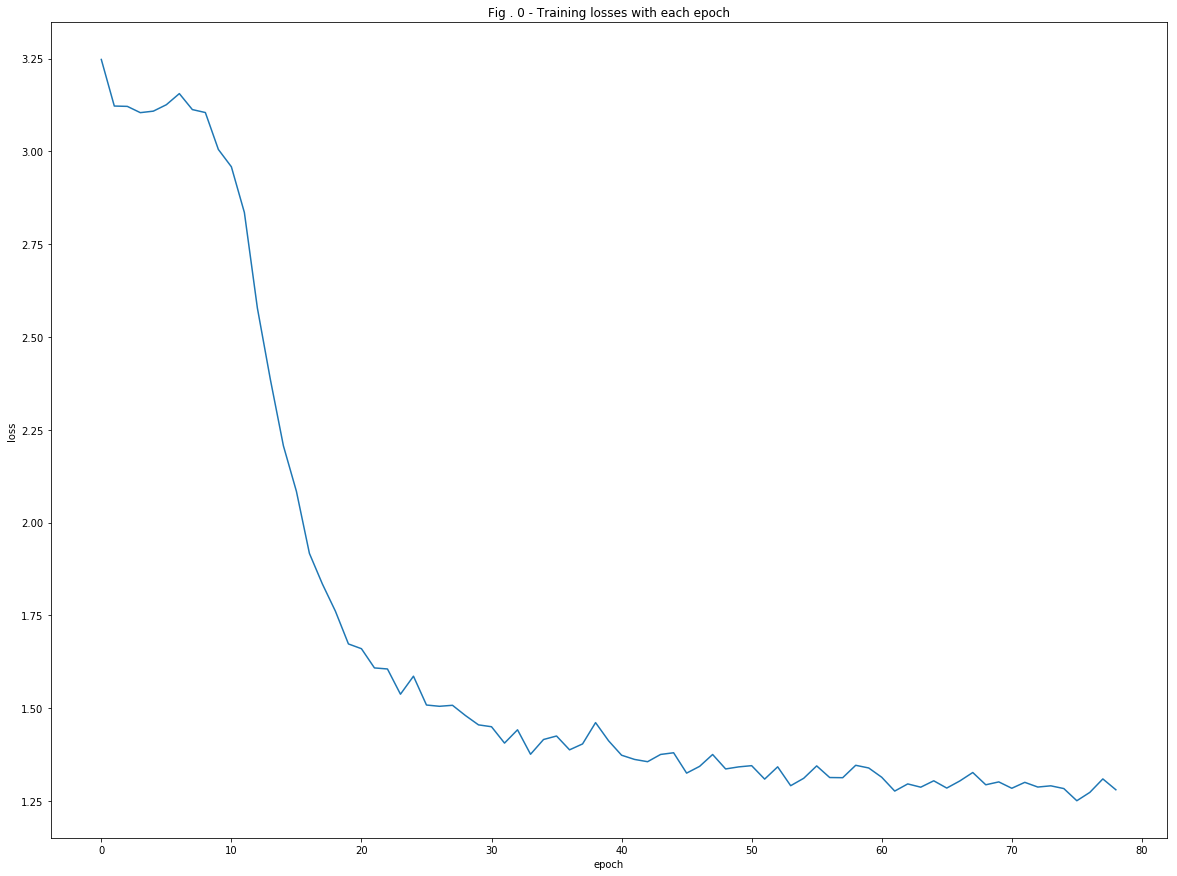

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 15))
plt.plot(training_loss)
plt.title('Fig . 0 - Training losses with each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

In [22]:
tf.train.get_checkpoint_state('checkpoints')

model_checkpoint_path: "checkpoints\\i3960_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i200_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i400_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i600_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i800_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1000_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1200_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1400_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1600_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i1800_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2000_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2200_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2400_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2600_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i2800_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i3000_l512.ckpt"
all_model_checkpoint_paths: "checkpoints\\i3200_l512.ckpt"
all_mo

## Sampling

Now that the network is trained, we'll can use it to generate new text. The idea is that we pass in a character, then the network will predict the next character. We can use the new one, to predict the next one. And we keep doing this to generate all new text. I also included some functionality to prime the network with some text by passing in a string and building up a state from that.

The network gives us predictions for each character. To reduce noise and make things a little less random, I'm going to only choose a new character from the top N most likely characters.



In [23]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

In [24]:
def sample(checkpoint, n_samples, lstm_size, vocab_size, prime="The "):
    samples = [c for c in prime]
    model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in prime:
            x = np.zeros((1, 1))
            x[0,0] = vocab_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, len(vocab))
            samples.append(int_to_vocab[c])
        
    return ''.join(samples)

Here, pass in the path to a checkpoint and sample from the network.

In [25]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints\\i3960_l512.ckpt'

In [43]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
samp = sample(checkpoint, 2000, lstm_size, len(vocab), prime="Far")
print(samp)

INFO:tensorflow:Restoring parameters from checkpoints\i3960_l512.ckpt
Fary, what's such
a meaning
of the same firmly seemed."

And she stretched to her, though he stowd the beating
children, and, still he wanted to go to her. Stepan Arkadyevitch had already to be all the boat, and
has never said.

"Yes, I will be so an old
party in the thing the
dead. The dog the
desperate soft close shadow, that I was taken into the strivive with the box too all with her honor, that he has said at tem his sense of his hands to me intenses of a position into sociated
in the porter and his house that had been stringer to be impate, bury
horror. It's try to say at it there to go into the carriage, who had thought of all these stand of he thrown at anything instead--her husband, the served, horse--he had sent the contempt were sure to go to the position
of all his huge attitude and head to be dance to him. "I will see," he said, still then--that was not the same still set her and all the servant, the clou

In [44]:
checkpoint = 'checkpoints/i200_l512.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

INFO:tensorflow:Restoring parameters from checkpoints/i200_l512.ckpt
Fars stshhtt    tse e t ts hhtste sht  t sesethshtheesht seesee  h ttee st teth  t  e s s eetesh   eteeee tsshs h t eet   h h  ssshsh sses eee t    es ht  h  t  s  hht  teetss ths  ees hsesssst  s   eeeshhe  ht  h e  hhst  htt tstth hh sh st  est hett  seeheeths t   tt s  tete ette ssh    e  s se etht ht theesh  h    eheseh se   hsese  tee s hsts e he  ehht e sthh eh  et t et h s eetee eets et ee  htt   hhthesh ett t eh   tste ets  e she e hh t hhs   ees h  e   setss e ets  t s ehees h e tt eeeest  s  httt  hshhh h e htee  tt h   teeths s hthhh hs  sse   t sst  teth  e ehtte   e e  th t te  tteeh eeh ehse  h hthes ehsseh e st et   te  h t tsttse eees    s e e  t ehtehhhhhteehsheh  eeteh sehet h tt s  sthht hhtts ttt estt  hhtt  eh htetttsht e hhe  eh h  hhs he e ett e tes etttee tsht th hete t  s tee s  es heseses e  se  steesh    ee thhh  hs thh  sthsh h h et  ehtes hhhete  s  shs  ees h ess tt sh t he ththh e  hetsh

In [45]:
checkpoint = 'checkpoints/i600_l512.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

INFO:tensorflow:Restoring parameters from checkpoints/i600_l512.ckpt
Fari s ni nesen se hir nindes senr n and sh t sa ane se sindat hh tos at nha sin sitee h se nhe nan nitirt ten s hiss aaner thars ti tes h h tosres te te sinsr thinn sirens te tee te nerriander aa nesterte the anse niss s te as a ande tin ho siress s tis ne th tith an te are tese n antersist atass tir nh n hh te n h tosess to thin s a  hon ne n siteessiseres thitast nher nene at tirs h testatine a sathe h n at ser as t th hissata his aat tone nhe s tise n hin t hirtet aate andet nerren nh tis hithes sesr hh sare sat he tensres nast at as nind the n tor asrensr nan nhe si tose sanse he at terr n sh n te tite nar se nater atase nhhises t hha ner tin hit asr, ne se atite n hee athita hite hin hirs hhest ner a a nann th n he ners an ter hhise sh heithi anentiat this teser tot ti ti nes athher ni t n s a tite se nas nineensen at nit ter tos ni nhe aaten nhe nh nind,ar hi hone antis ter n ane ne th nerite sass ne horr, ter 

In [46]:
checkpoint = 'checkpoints/i1200_l512.ckpt'
samp = sample(checkpoint, 1000, lstm_size, len(vocab), prime="Far")
print(samp)

INFO:tensorflow:Restoring parameters from checkpoints/i1200_l512.ckpt
Fare,
a man of step intence of a position. He was supposed
in his shouldy, he had been to teer. He would have speaking on
shalf the hands. And as he deaind the thing and at the position and stricked the seed in the children, the consering of the
platest the steps we whom to him to have so was
how she dear, and with her hat, with his hoom.

"Yes, In the most out of the praness," said Anna with her his strongen that, and
stepd the
sout of his hand at
all, the thrand that this
his so home him of the secirter, he went of
always as
he was a position, as she had stating to annosed over, and too was all that how she was
before all that all at the
passion, and he had been something. The tindering out of the same hand. The stood
at an ordin, but he saw any tee humbly and answer a displice that the soning to him of him at her that he
had that, was to say the thing his care is that there said at all their persants of this side.